In [1]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt

In [2]:


class MyLosses(object):

  def weighted_crossentropy(self, class_weights):
      def loss_fn(y_true, y_pred):
          # Apply softmax activation to logits
          y_pred = tf.nn.softmax(y_pred, axis=-1)

          # Flatten both inputs
          y_true_f = tf.reshape(y_true, [-1])
          y_pred_f = tf.reshape(y_pred, [-1, tf.shape(y_pred)[-1]])

          # Calculate weighted cross-entropy loss
          loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=tf.cast(y_true_f, dtype=tf.int32), logits=y_pred_f)
          weighted_loss = tf.reduce_mean(tf.multiply(loss, tf.gather(class_weights, tf.cast(y_true_f, dtype=tf.int32))))

          return weighted_loss

      return loss_fn

In [3]:
filepath = 'saved_seg_models/model2023-03-17 05_01_49.812997'

In [4]:
myloss = MyLosses()
loss = myloss.weighted_crossentropy(tf.constant([1.0, 5.33, 16.0]))
# learning rate scheduler
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9)

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2023-03-18 16:57:28.036671: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-18 16:57:28.037010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
model = tf.keras.models.load_model(
    filepath, compile=False, options=None
)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=loss,
    metrics=["accuracy"],
)

2023-03-18 16:57:39.857649: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-18 16:57:40.139743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 911ms/step


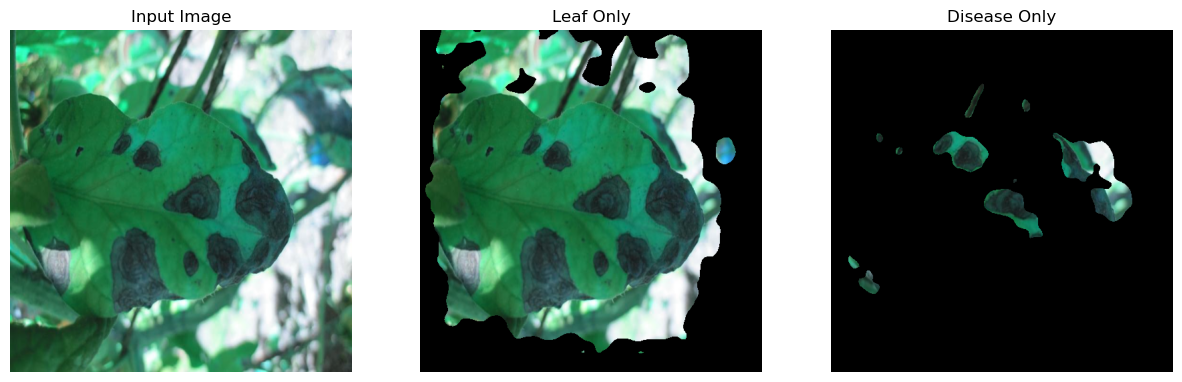

In [6]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'Leaf Only', 'Disease Only']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

img = cv2.imread('COCOdatasettomato/images/val/tomatoes_002_full_width.jpg')
img = cv2.resize(img, (512,512))

predmask = model.predict(img[tf.newaxis, ...])
predmask = create_mask(predmask)

leaf = cv2.bitwise_and(img, img, mask=cv2.inRange(predmask.numpy(), 1, 2))

diseased = cv2.bitwise_and(img, img, mask=cv2.inRange(predmask.numpy(), 2, 2))

display([img, leaf, diseased])

In [7]:
import numpy as np
mask = np.copy(predmask)
# Define the class labels
class_labels = {
    0: "Background",
    1: "Healthy",
    2: "Injured"
}
# Define the number of classes
num_classes = len(class_labels)

# Initialize the pixel counts for each class
pixel_counts = {class_labels[i]: 0 for i in range(num_classes)}

for class_label in class_labels:
    class_name = class_labels[class_label]
    class_pixels = np.sum(mask == class_label)
    pixel_counts[class_name] += class_pixels

# Print the resulting pixel counts for each class
for class_name in pixel_counts:
    print(f"{class_name}: {pixel_counts[class_name]}")

total_leaf = pixel_counts['Healthy'] + pixel_counts['Injured']
severity = (pixel_counts['Injured'] / total_leaf) * 100

print(severity)


total = pixel_counts['Background']+pixel_counts['Healthy']+pixel_counts['Injured'] 
bgd_weight = total/pixel_counts['Background']
hlt_weight = total/pixel_counts['Healthy']
inj_weight = total/pixel_counts['Injured']
# class_weights = tf.constant(bgd_weight, hlt_weight, inj_weight)
weights = [bgd_weight, hlt_weight, inj_weight]
weights = weights/np.sum(weights)
# class_weights = tf.constant(weights)
print(weights)


Background: 93368
Healthy: 154359
Injured: 14417
8.542091292600844
[0.12374524 0.07485048 0.80140428]
